In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.table import Table
from astropy import units as u
import astropy.constants
from astropy.io import ascii,fits

from telfit import Modeler

import scipy.ndimage as scipynd
from scipy.optimize import curve_fit
from astropy import  convolution


DEIMOS_RAW   = os.getenv('DEIMOS_RAW')

Create telluric synthetic models, binned at 0.02AA.   This choice is so that resolution is more than 10x larger than DEIMOS.

In [2]:
# RUN TELFIT SOFTWARE
# INSTALLED FROM https://github.com/freddavies/Telluric-Fitter-py3
# 
def run_telfit(h2o,o2):
    
    # DEIMOS WAVELENGTH RANGE
    wave_deimos = np.arange(6000,9600,0.02)  # DEFINE 0.01A GRID

    # HARDWIRE TO MAUNA KEA
    alt = 4.2
    lat = 19.8

    # START/END WAVELENGTH IN NM
    wavestart = 600.0
    waveend   = 960.0
           
    #GENERATE A TELLURIC SPECTRUM -- DEFAULT RESOLUTION 0.001AA
    modeler = Modeler()
    print(h2o,o2)

    model = modeler.MakeModel(humidity=h2o,o2=o2*1e5,
                          lowfreq=1e7/waveend,
                          highfreq=1e7/wavestart, lat=lat, alt=alt)

    tell = model.toarray()

    # CONVERT TO ANGSTRUM
    wave = 10. * tell[:,0]
    flux = tell[:,1]
    
    # DETERMINE BINNING
    bins = wave - np.roll(wave,1) 
    print('binning = ',np.median(bins))
    
    
    # SMOOTH AND REBIN TO LINEAR 0.02A PIXELS
    sig_res = 0.02/np.median(bins)
    print('Kernal ',sig_res)
    gauss_kernel = convolution.Gaussian1DKernel(sig_res)
    smooth_flux  = convolution.convolve(flux, gauss_kernel)

    tell_flux = np.interp(wave_deimos,wave,smooth_flux)

    plt.plot(wave,flux)
    plt.plot(wave_deimos,tell_flux)
    plt.xlim(6900,6910)
    
    return tell_flux

In [ ]:
# DEFINE 0.01A WAVELENGTH GRID
wave_deimos = np.arange(6000,9600,0.02)


In [ ]:
# GRID OF PARAMETERS

# FAKE VALUES BETWEEN H2O = 38 to 44
# 44. = 45 
# 42 = 44.2 done
# 40 = 37. done
# 38 = 36.5

# COARSE GRID POINTS
h2o_grid = 1.*np.arange(5,105,5) 
o2_grid = np.arange(0.7,2.2,0.05)

# FINE GRID POINTS
#h2o_grid = 1.*np.arange(2,102,2) 


In [ ]:
plt.figure(figsize=(14,5))

for h2o in h2o_grid:
    th2o = h2o
            
    for o2 in o2_grid:

        # EXTRA '_' for reading purposes
        outname = DEIMOS_DROPBOX + \
              '/templates/tellurics/new_telluric_0.02A_h2o_{}_o2_{:2.2f}_.fits'.format(int(h2o),o2)

        print(h2o,o2)
        
        twave = wave_deimos
        if not os.path.isfile(outname):
            tflux = run_telfit(th2o,o2)
            print(outname)

            t = Table([twave,tflux], names=('wave', 'flux'))
            t.meta['h2o'] = h2o
            t.meta['o2']  = o2

            t.write(outname, format='fits')

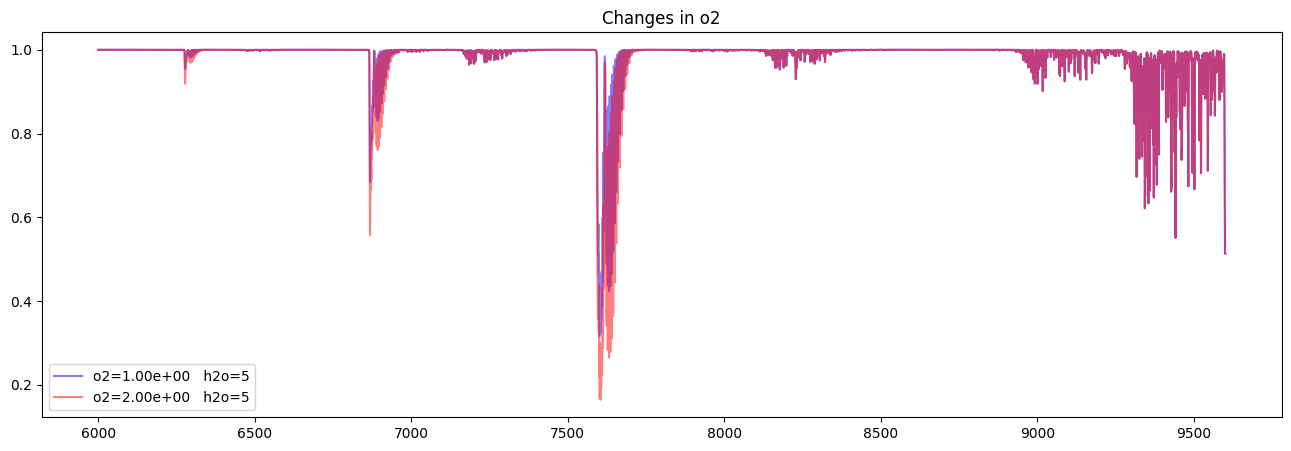

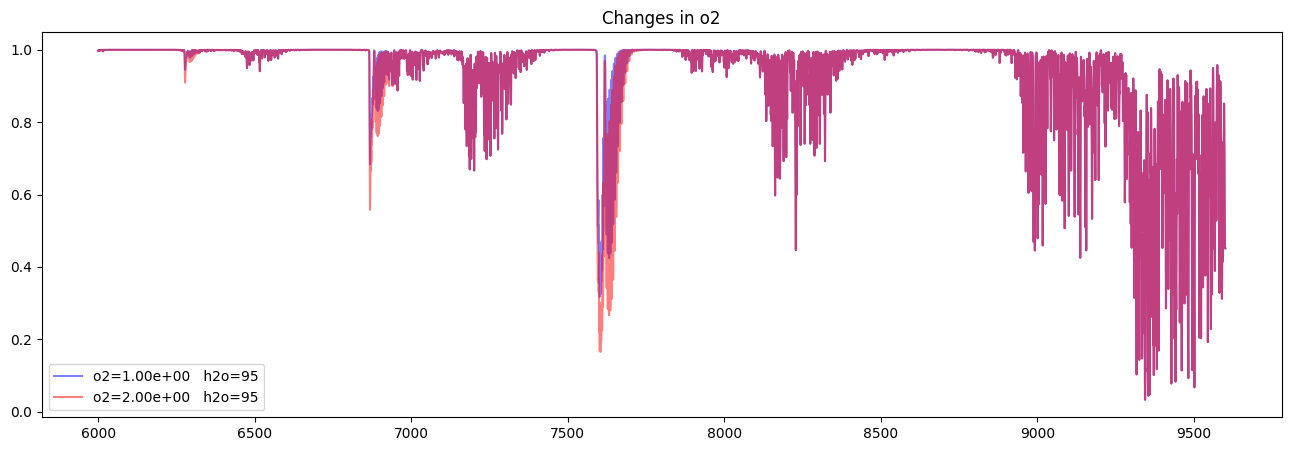

In [3]:
clr = ['blue','red']
h2o_val = np.array([5,95])
o2_val = np.array([1.0,2.0])

losvd_pix = 0.5/0.02

for h2o in h2o_val:
    
    plt.figure(figsize=(16,5))
    for o2,c in zip(o2_val,clr):
        tfile = DEIMOS_RAW + '/templates/tellurics/telluric_0.02A_h2o_{}_o2_{:2.2f}_.fits'.format(int(h2o),o2)
        
        hdu  = fits.open(tfile)
        data =  hdu[1].data
        twave = np.array(data['wave']).flatten()
        tflux = np.array(data['flux']).flatten()

        cflux = scipynd.gaussian_filter1d(tflux,losvd_pix)#,mode='nearest')
        t = 'o2={:0.2e}   h2o={:0.0f}'.format(o2,h2o)
        plt.plot(twave,cflux,alpha=0.5,label=t,color=c)
        plt.title('Changes in o2')

    plt.legend()
#plt.xlim(8200,8500)

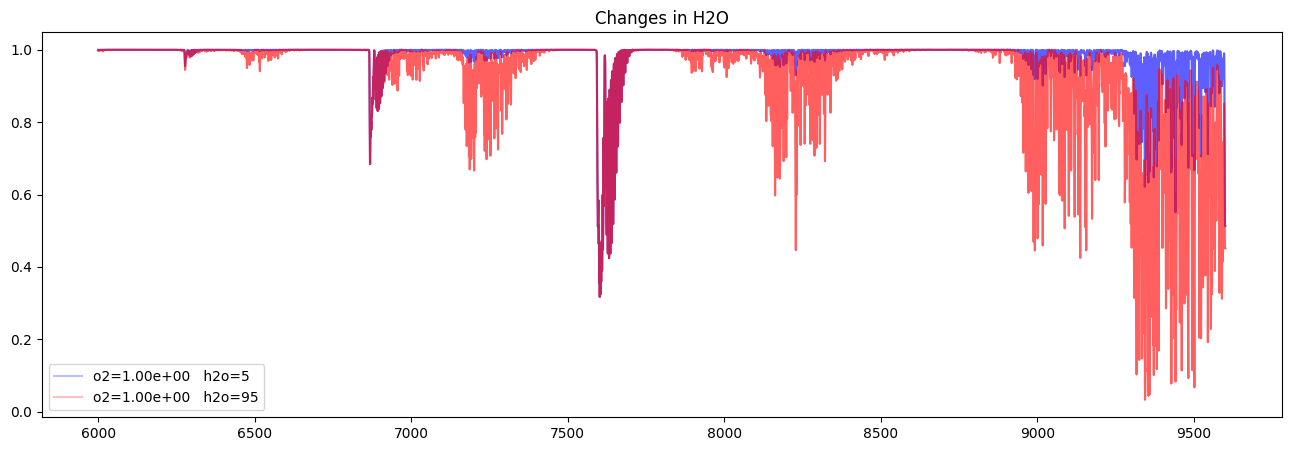

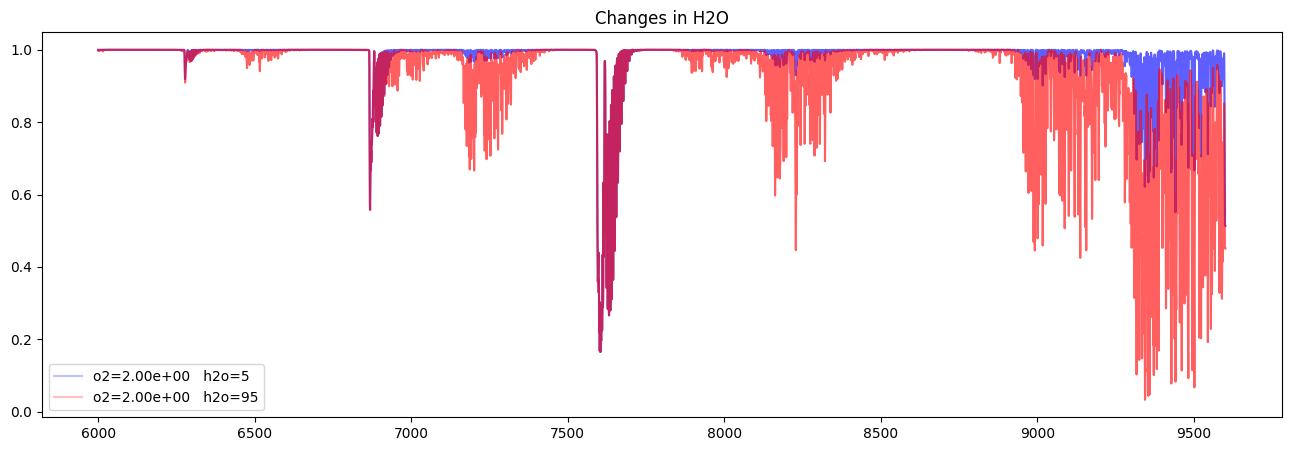

In [4]:
clr = ['blue','red']

for o2 in o2_val:
    
    plt.figure(figsize=(16,5))
    for h2o,c in zip(h2o_val,clr):
        tfile = DEIMOS_RAW + '/templates/tellurics/telluric_0.02A_h2o_{}_o2_{:2.2f}_.fits'.format(int(h2o),o2)
        
        hdu  = fits.open(tfile)
        data =  hdu[1].data
        twave = np.array(data['wave']).flatten()
        tflux = np.array(data['flux']).flatten()

 
        cflux = scipynd.gaussian_filter1d(tflux,losvd_pix)#,mode='nearest')
        plt.plot(twave,cflux,alpha=0.5,color=c)
        t = 'o2={:0.2e}   h2o={:0.0f}'.format(o2,h2o)
        plt.plot(twave,cflux,alpha=0.25,label=t,color=c)
        plt.title('Changes in H2O')
    plt.legend()
   # plt.xlim(8100,8350)